In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv("../../data/quarterly_data.csv", encoding = 'unicode_escape')

In [2]:
df1 = df.replace("..", np.nan)

In [3]:
df1

,Postal code,Building type,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",5458,5347,5826,5566,5545,5812,5909,5856,...,7755,8332,8130,8068,7802,8543,9170,7517,8872,8596
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",5164,5021,5081,5006,5713,5866,5552,5614,...,6914,7694,6901,7435,7573,7398,7868,7700,7829,7974
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",4944,5396,4828,5394,5571,5709,5450,5010,...,6883,6846,7379,6728,7205,6678,7178,7405,8053,8174
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,5168,5219,5181,5269,5632,5807,5630,5511,...,7043,7478,7476,7345,7460,7275,8058,7540,8188,8188
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, two-room flat",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10070,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, three-room flat+",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10071,99980 Utsjoki Keskus (Utsjoki ),Blocks of flats total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10072,99980 Utsjoki Keskus (Utsjoki ),Terraced houses total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# original source https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
# summarize the number of rows with missing values for each column
for i in range(df1.shape[1]):
    n_miss = df1.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 8466 (84.0%)
> 3, Missing: 8371 (83.1%)
> 4, Missing: 8437 (83.8%)
> 5, Missing: 8470 (84.1%)
> 6, Missing: 8429 (83.7%)
> 7, Missing: 8383 (83.2%)
> 8, Missing: 8401 (83.4%)
> 9, Missing: 8676 (86.1%)
> 10, Missing: 8517 (84.5%)
> 11, Missing: 8388 (83.3%)
> 12, Missing: 7979 (79.2%)
> 13, Missing: 8071 (80.1%)
> 14, Missing: 8538 (84.8%)
> 15, Missing: 8544 (84.8%)
> 16, Missing: 8596 (85.3%)
> 17, Missing: 8736 (86.7%)
> 18, Missing: 8683 (86.2%)
> 19, Missing: 8637 (85.7%)
> 20, Missing: 8653 (85.9%)
> 21, Missing: 8760 (87.0%)
> 22, Missing: 8687 (86.2%)
> 23, Missing: 8612 (85.5%)
> 24, Missing: 8579 (85.2%)
> 25, Missing: 8677 (86.1%)
> 26, Missing: 8747 (86.8%)
> 27, Missing: 8551 (84.9%)
> 28, Missing: 8647 (85.8%)
> 29, Missing: 8769 (87.0%)
> 30, Missing: 8640 (85.8%)
> 31, Missing: 8682 (86.2%)
> 32, Missing: 8575 (85.1%)
> 33, Missing: 8739 (86.7%)
> 34, Missing: 8721 (86.6%)
> 35, Missing: 8655 (85.9%)
> 36, Miss

In [5]:
## Categories and numerical features to different dfs

cat = df1.iloc[:,0:2]
num = df1.iloc[:,2:]
num_columns = num.columns

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
num_imp = imp.fit_transform(num)

/Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
df_num_imp = pd.DataFrame(num_imp, columns=num_columns)
df_num_imp

,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),2012Q1 Price per square meter (EUR/m2),2012Q2 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,5458.000000,5347.000000,5826.000000,5566.000000,5545.000000,5812.000000,5909.000000,5856.000000,5785.000000,6436.000000,...,7755.000000,8332.000000,8130.000000,8068.0000,7802.000000,8543.000000,9170.000000,7517.000000,8872.000000,8596.000000
1,5164.000000,5021.000000,5081.000000,5006.000000,5713.000000,5866.000000,5552.000000,5614.000000,6020.000000,5814.000000,...,6914.000000,7694.000000,6901.000000,7435.0000,7573.000000,7398.000000,7868.000000,7700.000000,7829.000000,7974.000000
2,4944.000000,5396.000000,4828.000000,5394.000000,5571.000000,5709.000000,5450.000000,5010.000000,5704.000000,5466.000000,...,6883.000000,6846.000000,7379.000000,6728.0000,7205.000000,6678.000000,7178.000000,7405.000000,8053.000000,8174.000000
3,5168.000000,5219.000000,5181.000000,5269.000000,5632.000000,5807.000000,5630.000000,5511.000000,5843.000000,5899.000000,...,7043.000000,7478.000000,7476.000000,7345.0000,7460.000000,7275.000000,8058.000000,7540.000000,8188.000000,8188.000000
4,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10070,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10071,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173
10072,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,1900.623898,1930.519312,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173


In [8]:
df_num_imp.isnull().sum()

2010Q1 Price per square meter (EUR/m2)     0
2010Q2 Price per square meter (EUR/m2)     0
2010Q3 Price per square meter (EUR/m2)     0
2010Q4 Price per square meter (EUR/m2)     0
2011Q1 Price per square meter (EUR/m2)     0
2011Q2 Price per square meter (EUR/m2)     0
2011Q3 Price per square meter (EUR/m2)     0
2011Q4 Price per square meter (EUR/m2)     0
2012Q1 Price per square meter (EUR/m2)     0
2012Q2 Price per square meter (EUR/m2)     0
2012Q3 Price per square meter (EUR/m2)     0
2012Q4 Price per square meter (EUR/m2)     0
2013Q1 Price per square meter (EUR/m2)     0
2013Q2 Price per square meter (EUR/m2)     0
2013Q3 Price per square meter (EUR/m2)     0
2013Q4 Price per square meter (EUR/m2)     0
2014Q1 Price per square meter (EUR/m2)     0
2014Q2 Price per square meter (EUR/m2)     0
2014Q3 Price per square meter (EUR/m2)     0
2014Q4 Price per square meter (EUR/m2)     0
2015Q1 Price per square meter (EUR/m2)     0
2015Q2 Price per square meter (EUR/m2)     0
2015Q3 Pri

In [9]:
df_imp = pd.concat([cat, df_num_imp],axis=1)

In [10]:
df_imp.head()

,Postal code,Building type,2010Q1 Price per square meter (EUR/m2),2010Q2 Price per square meter (EUR/m2),2010Q3 Price per square meter (EUR/m2),2010Q4 Price per square meter (EUR/m2),2011Q1 Price per square meter (EUR/m2),2011Q2 Price per square meter (EUR/m2),2011Q3 Price per square meter (EUR/m2),2011Q4 Price per square meter (EUR/m2),...,2019Q1 Price per square meter (EUR/m2),2019Q2 Price per square meter (EUR/m2),2019Q3 Price per square meter (EUR/m2),2019Q4 Price per square meter (EUR/m2),2020Q1 Price per square meter (EUR/m2),2020Q2 Price per square meter (EUR/m2),2020Q3 Price per square meter (EUR/m2),2020Q4 Price per square meter (EUR/m2),2021Q1* Price per square meter (EUR/m2),2021Q2* Price per square meter (EUR/m2)
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",5458.000000,5347.000000,5826.000000,5566.000000,5545.000000,5812.000000,5909.000000,5856.000000,...,7755.000000,8332.000000,8130.000000,8068.0000,7802.000000,8543.000000,9170.000000,7517.000000,8872.000000,8596.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",5164.000000,5021.000000,5081.000000,5006.000000,5713.000000,5866.000000,5552.000000,5614.000000,...,6914.000000,7694.000000,6901.000000,7435.0000,7573.000000,7398.000000,7868.000000,7700.000000,7829.000000,7974.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",4944.000000,5396.000000,4828.000000,5394.000000,5571.000000,5709.000000,5450.000000,5010.000000,...,6883.000000,6846.000000,7379.000000,6728.0000,7205.000000,6678.000000,7178.000000,7405.000000,8053.000000,8174.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,5168.000000,5219.000000,5181.000000,5269.000000,5632.000000,5807.000000,5630.000000,5511.000000,...,7043.000000,7478.000000,7476.000000,7345.0000,7460.000000,7275.000000,8058.000000,7540.000000,8188.000000,8188.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,1783.222523,1824.975495,1837.301766,1822.620585,1869.018392,1898.716837,1894.228569,1862.702913,...,2084.801645,2117.757075,2101.019245,2069.1361,2135.629373,2152.308609,2173.893109,2172.261334,2219.056507,2290.004173


In [11]:
df4 = df_imp.melt(id_vars=["Postal code", "Building type"],var_name="Quarter", value_name="EUR/m2")

In [12]:
df4.loc[df4["Postal code"] == "00100 Helsinki Keskusta - Etu-Töölö   (Helsinki )"]

,Postal code,Building type,Quarter,EUR/m2
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",2010Q1 Price per square meter (EUR/m2),5458.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2010Q1 Price per square meter (EUR/m2),5164.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2010Q1 Price per square meter (EUR/m2),4944.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2010Q1 Price per square meter (EUR/m2),5168.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2010Q1 Price per square meter (EUR/m2),1783.222523
...,...,...,...,...
453331,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2021Q2* Price per square meter (EUR/m2),7974.000000
453332,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2021Q2* Price per square meter (EUR/m2),8174.000000
453333,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2021Q2* Price per square meter (EUR/m2),8188.000000
453334,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2021Q2* Price per square meter (EUR/m2),2290.004173


In [13]:
### Regex to change quarters to datetime
import datetime as date

def quarter_to_datetime(row):
    dates = {"Q1": "1/1", "Q2":"1/4", "Q3":"1/7", "Q4":"1/10"}
    string = row.replace("*", "").split(" ")[0]
    year, quarter = string[:4], string[4:]
    datetime_str = dates[quarter] + "/" + year
    return date.datetime.strptime(datetime_str, '%d/%m/%Y')
    
    
df4["Quarter"] = df4["Quarter"].apply(lambda row: quarter_to_datetime(row))
df4

,Postal code,Building type,Quarter,EUR/m2
0,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, one-room flat",2010-01-01,5458.000000
1,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, two-room flat",2010-01-01,5164.000000
2,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),"Blocks of flats, three-room flat+",2010-01-01,4944.000000
3,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Blocks of flats total,2010-01-01,5168.000000
4,00100 Helsinki Keskusta - Etu-Töölö (Helsinki ),Terraced houses total,2010-01-01,1783.222523
...,...,...,...,...
463399,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, two-room flat",2021-04-01,2290.004173
463400,99980 Utsjoki Keskus (Utsjoki ),"Blocks of flats, three-room flat+",2021-04-01,2290.004173
463401,99980 Utsjoki Keskus (Utsjoki ),Blocks of flats total,2021-04-01,2290.004173
463402,99980 Utsjoki Keskus (Utsjoki ),Terraced houses total,2021-04-01,2290.004173


In [14]:
### Split postal code and place

df4[['Postal code', 'Location']] = df4['Postal code'].str.split(' ', 1, expand=True)
df4

,Postal code,Building type,Quarter,EUR/m2,Location
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
3,00100,Blocks of flats total,2010-01-01,5168.000000,Helsinki Keskusta - Etu-Töölö (Helsinki )
4,00100,Terraced houses total,2010-01-01,1783.222523,Helsinki Keskusta - Etu-Töölö (Helsinki )
...,...,...,...,...,...
463399,99980,"Blocks of flats, two-room flat",2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki )
463400,99980,"Blocks of flats, three-room flat+",2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki )
463401,99980,Blocks of flats total,2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki )
463402,99980,Terraced houses total,2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki )


In [15]:
import pgeocode
import time

In [16]:
postal_code_list = list(df4["Postal code"].unique())
nomi = pgeocode.Nominatim('fi')
location = nomi.query_postal_code(postal_code_list)

In [17]:
location

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,00100,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1714,24.9316,6.0
1,00120,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1632,24.9391,6.0
2,00130,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1645,24.9487,6.0
3,00140,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1578,24.9525,6.0
4,00150,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1570,24.9369,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1674,99830,FI,Saariselkä,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.4230,27.3965,6.0
1675,99870,FI,Inari,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.9287,26.9896,6.0
1676,99930,FI,Sevettijärvi,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,69.4918,28.5786,4.0
1677,99950,FI,Karigasniemi,Lapland,19.0,Pohjois-Lappi,197.0,Utsjoki,890.0,69.4729,25.9527,4.0


In [18]:
cond = location['latitude'].isna()
jalla = location.assign(cond1= cond)
jalla

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy,cond1
0,00100,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1714,24.9316,6.0,False
1,00120,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1632,24.9391,6.0,False
2,00130,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1645,24.9487,6.0,False
3,00140,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1578,24.9525,6.0,False
4,00150,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1570,24.9369,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,99830,FI,Saariselkä,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.4230,27.3965,6.0,False
1675,99870,FI,Inari,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,68.9287,26.9896,6.0,False
1676,99930,FI,Sevettijärvi,Lapland,19.0,Pohjois-Lappi,197.0,Inari,148.0,69.4918,28.5786,4.0,False
1677,99950,FI,Karigasniemi,Lapland,19.0,Pohjois-Lappi,197.0,Utsjoki,890.0,69.4729,25.9527,4.0,False


In [19]:
## Find rows which are empty
# Source https://www.kite.com/python/answers/how-to-find-rows-with-nan-values-in-a-pandas-dataframe-in-python


is_NaN = location.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = location[row_has_NaN]
rows_with_NaN

,postal_code,country_code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
37,00540,FI,Helsinki,Uusimaa,1.0,Helsinki,11.0,Helsinki,91.0,60.1841,24.9785,NaN
289,08450,FI,Lohja,Uusimaa,1.0,Helsinki,11.0,Lohja,444.0,60.2713,23.9952,NaN
294,09120,FI,Karjalohja,Uusimaa,1.0,Helsinki,11.0,Lohja,444.0,60.2506,23.7101,NaN
307,10440,FI,Bollsta,Uusimaa,1.0,Raaseporin,14.0,Raseborg,710.0,60.1126,23.5225,NaN
317,10710,FI,Snappertuna,Uusimaa,1.0,Raaseporin,14.0,Raseborg,710.0,59.9782,23.7238,NaN
440,20100,FI,Turku,Southwest Finland,2.0,Turku,23.0,Turku,853.0,60.4449,22.2261,NaN
565,25650,FI,Strömma,Southwest Finland,2.0,Åboland-Turunmaa,21.0,Kimitoön,322.0,60.1888,22.8499,NaN
576,26410,FI,Kaaro,Satakunta,4.0,Rauma,41.0,Rauma,684.0,61.1767,21.5183,NaN
852,41350,FI,Laukaa As,Central Finland Region,13.0,Jyväskylä,131.0,Laukaa,410.0,62.4267,25.8850,NaN
859,41530,FI,Veneranta,Central Finland Region,13.0,Jyväskylä,131.0,Hankasalmi,77.0,62.3759,26.3465,NaN


In [20]:
###. WORK IN PROGRESS (93999 FOR KUUSAMO)
# THIS HAS TO BE ADDED MANUALLY

wanted_features_location = location[["postal_code", 
                                     "place_name", 
                                     "state_name", 
                                     "county_name", 
                                     "latitude", 
                                     "longitude"]]
wanted_features_location = wanted_features_location.rename(columns={"postal_code": "Postal code"})

In [21]:
df_merge = pd.merge(df4, wanted_features_location, on="Postal code")

In [22]:
df_merge

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude
0,00100,"Blocks of flats, one-room flat",2010-01-01,5458.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
1,00100,"Blocks of flats, two-room flat",2010-01-01,5164.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
2,00100,"Blocks of flats, three-room flat+",2010-01-01,4944.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
3,00100,Blocks of flats total,2010-01-01,5168.000000,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
4,00100,Terraced houses total,2010-01-01,1783.222523,Helsinki Keskusta - Etu-Töölö (Helsinki ),Helsinki,Uusimaa,Helsinki,60.1714,24.9316
...,...,...,...,...,...,...,...,...,...,...
463399,99980,"Blocks of flats, two-room flat",2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463400,99980,"Blocks of flats, three-room flat+",2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463401,99980,Blocks of flats total,2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907
463402,99980,Terraced houses total,2021-04-01,2290.004173,Utsjoki Keskus (Utsjoki ),Utsjoki,Lapland,Pohjois-Lappi,69.8467,26.8907


In [23]:
#Some columns are missing their geolocation features :(

for i in range(df_merge.shape[1]):
    n_miss = df_merge.iloc[:,i].isnull().sum()
    perc = n_miss / df1.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 0 (0.0%)
> 4, Missing: 0 (0.0%)
> 5, Missing: 276 (2.7%)
> 6, Missing: 276 (2.7%)
> 7, Missing: 276 (2.7%)
> 8, Missing: 276 (2.7%)
> 9, Missing: 276 (2.7%)


In [24]:
df_merge.columns

Index(['Postal code', 'Building type', 'Quarter', 'EUR/m2', 'Location',
       'place_name', 'state_name', 'county_name', 'latitude', 'longitude'],
      dtype='object')

In [25]:
df_merge["Building type"].unique()

array(['Blocks of flats, one-room flat', 'Blocks of flats, two-room flat',
       'Blocks of flats, three-room flat+', 'Blocks of flats total',
       'Terraced houses total', 'Building types total'], dtype=object)

# Save a dataset for model testing

In [26]:
wanted_columns = ['Postal code', 'Building type', 'Quarter', 'EUR/m2','latitude', 'longitude']
not_wanted_building_types = ['Building types total','Blocks of flats total']
df_only_houses = df_merge[~df_merge["Building type"].isin(not_wanted_building_types)].reset_index(drop=True)
df_only_houses["EUR/m2"] = df_only_houses["EUR/m2"].astype(int)

In [27]:
df_only_houses["Building type"].unique()

array(['Blocks of flats, one-room flat', 'Blocks of flats, two-room flat',
       'Blocks of flats, three-room flat+', 'Terraced houses total'],
      dtype=object)

In [28]:
### Rename building types


def rename_building(row):
    dic = {'Blocks of flats, one-room flat':'one-room','Blocks of flats, two-room flat':'two-room',
           'Blocks of flats, three-room flat+':'three or more room', 'Terraced houses total':'terrace house'}
    return dic[row]

df_only_houses2 = df_only_houses
df_only_houses2["Building type"] = df_only_houses2["Building type"].apply(lambda r: rename_building(r))

In [29]:
data = df_only_houses2[wanted_columns]

In [30]:
data.head()

,Postal code,Building type,Quarter,EUR/m2,latitude,longitude
0,00100,one-room,2010-01-01,5458,60.1714,24.9316
1,00100,two-room,2010-01-01,5164,60.1714,24.9316
2,00100,three or more room,2010-01-01,4944,60.1714,24.9316
3,00100,terrace house,2010-01-01,1783,60.1714,24.9316
4,00100,one-room,2010-04-01,5347,60.1714,24.9316


In [31]:
data.to_csv("df_geo_imp.csv")

## Value of square meter of cities Q2 2021

In [32]:
Q2_2021__one_room = df_merge[(df_merge["Quarter"] == "2021-01-04") & (df_merge["Building type"] == "Blocks of flats, one-room flat")]


In [33]:
Q2_2021__one_room

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Q2 2021 Blocks of flats, one-room flat')

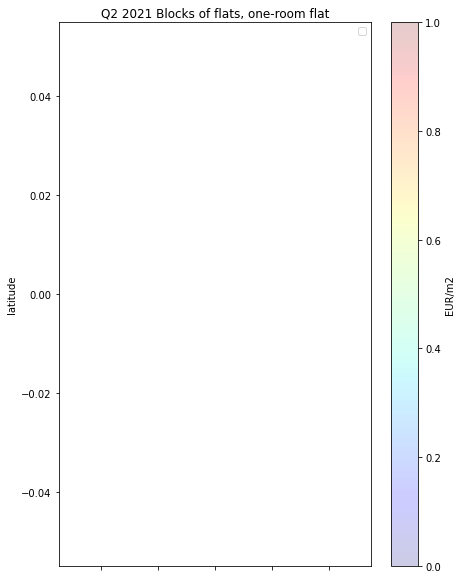

In [34]:
Q2_2021__one_room.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.title("Q2 2021 Blocks of flats, one-room flat")

### Only Helsinki

No handles with labels found to put in legend.


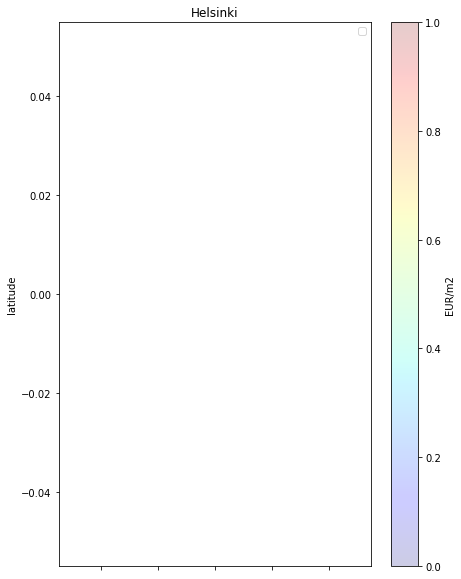

In [35]:
helsinki_df = Q2_2021__one_room[Q2_2021__one_room["county_name"] == "Helsinki"]

helsinki_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title("Helsinki")
plt.legend()

## Whole uusimaa

No handles with labels found to put in legend.


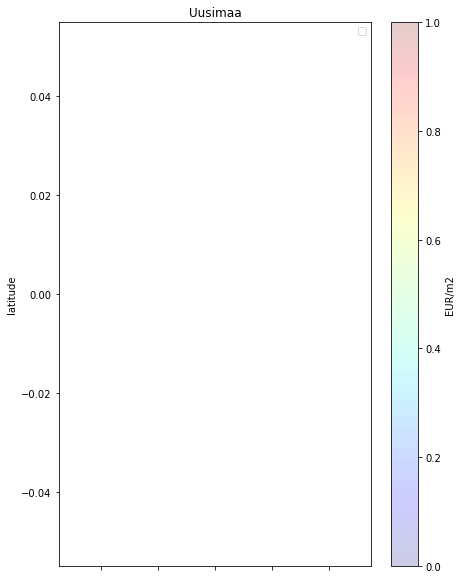

In [36]:
uusimaa_df = Q2_2021__one_room[Q2_2021__one_room["state_name"] == "Uusimaa"]

uusimaa_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, figsize=(7,10),
 c="EUR/m2", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.title("Uusimaa")
plt.legend()

In [37]:
uusimaa_df.describe()

,EUR/m2,latitude,longitude
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [38]:
helsinki_df.sort_values(by="EUR/m2", ascending=False).head()

,Postal code,Building type,Quarter,EUR/m2,Location,place_name,state_name,county_name,latitude,longitude


## Model prototype (just for testing web app)

It is worth noticing that this model has been built with imputed data. 
Therefore, model's evaluation can be wrong since the imputed data has been used for that step. 

In [39]:
import joblib


data.head()
data2 = data.drop("Postal code", axis=1)
data2["Quarter"] = data2["Quarter"].astype(str)

In [40]:
data2.isna().sum()

Building type      0
Quarter            0
EUR/m2             0
latitude         184
longitude        184
dtype: int64

In [41]:
data3 = data2.dropna().reset_index()

In [42]:
# Building type and Quarter to one hot encoding
from sklearn.preprocessing import OneHotEncoder

num = data3[["longitude", "latitude", "EUR/m2"]]
cat = data3[["Building type", "Quarter"]]

In [43]:
cat

,Building type,Quarter
0,one-room,2010-01-01
1,two-room,2010-01-01
2,three or more room,2010-01-01
3,terrace house,2010-01-01
4,one-room,2010-04-01
...,...,...
308747,terrace house,2021-01-01
308748,one-room,2021-04-01
308749,two-room,2021-04-01
308750,three or more room,2021-04-01


In [44]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cat)
oh_cat = enc.transform(cat).toarray()

In [45]:
oh_cat_features = enc.get_feature_names(["Building type", "Quarter"])
cat_df = pd.DataFrame(oh_cat, columns=oh_cat_features)

/Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
# Save encoder for streamlit
joblib.dump(enc, "onehot_encoder.pkl", compress=1)

['onehot_encoder.pkl']

In [47]:
data4 = pd.concat([cat_df,num],axis=1)
data4

,Building type_one-room,Building type_terrace house,Building type_three or more room,Building type_two-room,Quarter_2010-01-01,Quarter_2010-04-01,Quarter_2010-07-01,Quarter_2010-10-01,Quarter_2011-01-01,Quarter_2011-04-01,...,Quarter_2019-10-01,Quarter_2020-01-01,Quarter_2020-04-01,Quarter_2020-07-01,Quarter_2020-10-01,Quarter_2021-01-01,Quarter_2021-04-01,longitude,latitude,EUR/m2
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,5458
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,5164
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,4944
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,1783
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.9316,60.1714,5347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.8907,69.8467,2219
308748,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.8907,69.8467,2290
308749,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.8907,69.8467,2290
308750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.8907,69.8467,2290


In [48]:
cat_test = np.array(["one-room", "2021-01-04"])
tuloe = enc.transform(cat_test.reshape(1,-1)).toarray()
print(tuloe)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


/Users/kenriippa/Documents/School/OP-Forecasting-Future-House-Prices/venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [49]:
## Test and train sets

train = data4[data4["Quarter_2021-01-04"] == 0.0]
test = data4[data4["Quarter_2021-01-04"] == 1.0]

KeyError: 'Quarter_2021-01-04'

In [ ]:
X_feat = list(data4.columns)
X_feat.remove('EUR/m2')

X_train, X_test = train[X_feat], test[X_feat]
y_train, y_test = train['EUR/m2'], test['EUR/m2']


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


regr = RandomForestRegressor(n_estimators=10, random_state=7)
regr.fit(X_train, y_train)

pred = regr.predict(X_test)
mean_absolute_error(y_test, pred)

In [ ]:
joblib.dump(regr,'housing_regr.pkl',compress=1)

# Time series forecasting

In [95]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
import pandas as pd

In [96]:
df = pd.read_csv("../Bruce/no_nans.csv")

In [97]:
df["time"] = df["time"].apply(lambda row: quarter_to_datetime(row))
postal_codes = list(df.columns)[1:]

In [98]:
df.head()

,time,00100,00260,00360,00500,00520,00730,00820,01280,01300,...,33200,33560,33580,33710,33820,33850,33960,36200,37120,40520
0,2010-01-01,5168.0,4873.0,2756.0,4058.0,3317.0,3006.0,2652.0,2098.0,2616.0,...,2827.0,1951.0,2152.0,1760.0,1859.0,1227.0,1897.0,1747.0,1613.0,1968.0
1,2010-04-01,5219.0,5086.0,3051.0,4111.0,3706.0,3070.0,2561.0,2045.0,2688.0,...,3094.0,1816.0,2039.0,1803.0,1970.0,1254.0,2026.0,1659.0,1542.0,2110.0
2,2010-07-01,5181.0,4939.0,2889.0,4247.0,3672.0,2944.0,2632.0,2210.0,2814.0,...,3001.0,2081.0,1978.0,1851.0,1916.0,1338.0,1700.0,1851.0,1582.0,2096.0
3,2010-10-01,5269.0,4906.0,3037.0,4226.0,3681.0,3046.0,2580.0,2359.0,2727.0,...,2990.0,1963.0,2102.0,1740.0,1980.0,1287.0,1881.0,1715.0,1745.0,2180.0
4,2011-01-01,5632.0,5272.0,3188.0,4342.0,3654.0,3061.0,2793.0,2165.0,2734.0,...,3122.0,2142.0,2181.0,1838.0,1851.0,1398.0,1847.0,1836.0,1660.0,2116.0


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    46 non-null     datetime64[ns]
 1   00100   46 non-null     float64       
 2   00260   46 non-null     float64       
 3   00360   46 non-null     float64       
 4   00500   46 non-null     float64       
 5   00520   46 non-null     float64       
 6   00730   46 non-null     float64       
 7   00820   46 non-null     float64       
 8   01280   46 non-null     float64       
 9   01300   46 non-null     float64       
 10  01450   46 non-null     float64       
 11  02200   46 non-null     float64       
 12  02210   46 non-null     float64       
 13  02320   46 non-null     float64       
 14  02400   46 non-null     float64       
 15  02760   46 non-null     float64       
 16  03100   46 non-null     float64       
 17  04410   46 non-null     float64       
 18  06100   46 n

In [100]:
# Just testing with 00100

df_00100 = df[["00100", "time"]]
df_00100 = df_00100.rename(columns={"00100":"y","time":"ds"})
df_00100.tail()

,y,ds
41,7275.0,2020-04-01
42,8058.0,2020-07-01
43,7540.0,2020-10-01
44,8188.0,2021-01-01
45,8188.0,2021-04-01


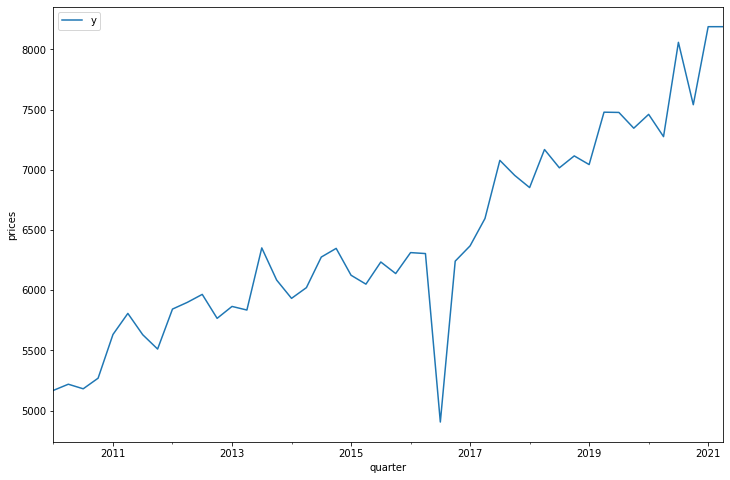

In [101]:
ax = df_00100.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel("prices")
ax.set_xlabel('quarter')

plt.show()

In [102]:
df_00100["ds"]

0    2010-01-01
1    2010-04-01
2    2010-07-01
3    2010-10-01
4    2011-01-01
5    2011-04-01
6    2011-07-01
7    2011-10-01
8    2012-01-01
9    2012-04-01
10   2012-07-01
11   2012-10-01
12   2013-01-01
13   2013-04-01
14   2013-07-01
15   2013-10-01
16   2014-01-01
17   2014-04-01
18   2014-07-01
19   2014-10-01
20   2015-01-01
21   2015-04-01
22   2015-07-01
23   2015-10-01
24   2016-01-01
25   2016-04-01
26   2016-07-01
27   2016-10-01
28   2017-01-01
29   2017-04-01
30   2017-07-01
31   2017-10-01
32   2018-01-01
33   2018-04-01
34   2018-07-01
35   2018-10-01
36   2019-01-01
37   2019-04-01
38   2019-07-01
39   2019-10-01
40   2020-01-01
41   2020-04-01
42   2020-07-01
43   2020-10-01
44   2021-01-01
45   2021-04-01
Name: ds, dtype: datetime64[ns]

In [132]:
# Setting up the model
prop = Prophet(interval_width=0.95)

In [150]:
train, test = df_00100[:-4], df_00100[-4:]

In [134]:
prop.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -52.7935
Iteration  1. Log joint probability =     81.067. Improved by 133.86.
Iteration  2. Log joint probability =    105.143. Improved by 24.076.
Iteration  3. Log joint probability =    113.938. Improved by 8.79479.
Iteration  4. Log joint probability =    114.836. Improved by 0.897786.
Iteration  5. Log joint probability =    115.207. Improved by 0.371794.
Iteration  6. Log joint probability =    115.298. Improved by 0.0902768.
Iteration  7. Log joint probability =    115.375. Improved by 0.0774581.
Iteration  8. Log joint probability =    115.429. Improved by 0.0543558.
Iteration  9. Log joint probability =    115.493. Improved by 0.0630725.
Iteration 10. Log joint probability =    115.541. Improved by 0.0485879.
Iteration 11. Log joint probability =    115.654. Improved by 0.112801.
Iteration 12. Log joint probability =    115.717. Improved by 0.0631605.
Iteration 13. Log joint probability =    115.798. Improved by 0.0806127.
Iteration 14. Log joi

In [144]:
def make_dates_from_string(string):
    return date.datetime.strptime(string, '%d/%m/%Y')

old_dates = prop.make_future_dataframe(periods=0)
"""future_dates = ["1/7/2021", "1/10/2021", 
                "1/1/2022", "1/4/2022", "1/7/2022", "1/10/2022", 
                "1/1/2023", "1/4/2023", "1/7/2023", "1/10/2023",
                "1/1/2024", "1/4/2024"]"""
future_dates = ["1/7/2020", "1/10/2020", "1/1/2021", "1/4/2021"]
dates = [make_dates_from_string(d) for d in future_dates]
future_df = pd.DataFrame({"ds": dates})
future_dates_df = pd.concat([old_dates,future_df]).reset_index(drop=True)

In [145]:
forecast = prop.predict(future_dates_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-01,5251.066892,4744.097917,5773.297675
1,2010-04-01,5381.115332,4868.455677,5901.185134
2,2010-07-01,5489.532322,4991.307693,6024.359092
3,2010-10-01,5444.761393,4933.901908,5955.470367
4,2011-01-01,5493.245462,4964.772607,5957.856809


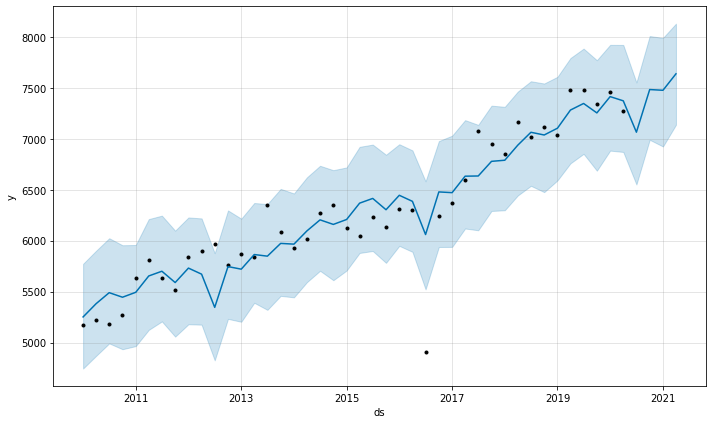

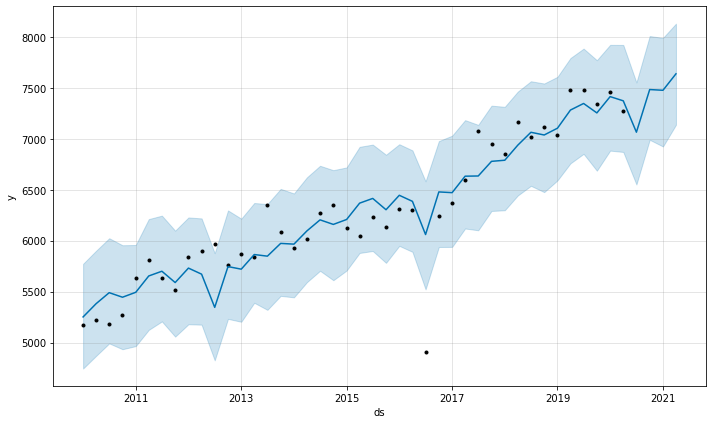

In [146]:
prop.plot(forecast, uncertainty=True)

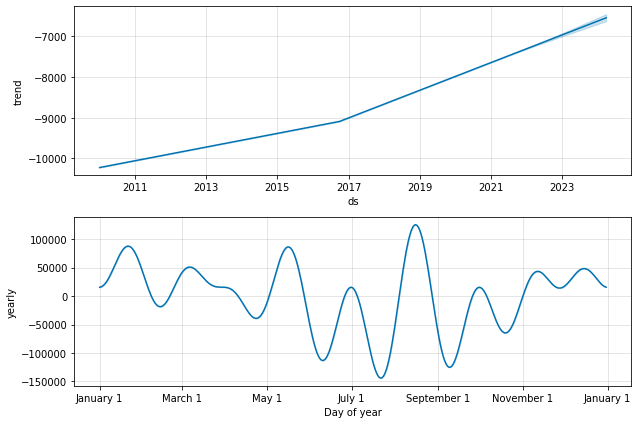

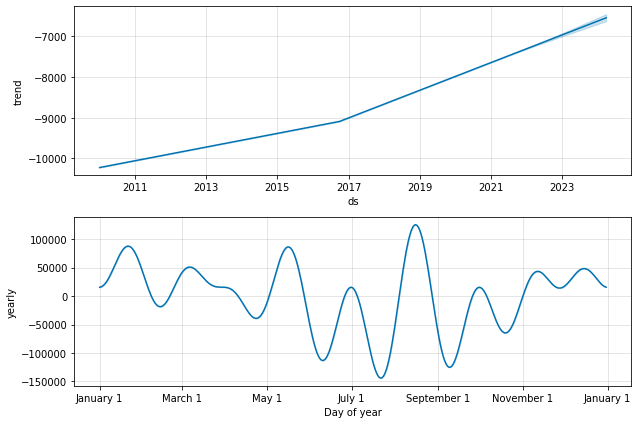

In [108]:
prop.plot_components(forecast)

<AxesSubplot:xlabel='ds'>

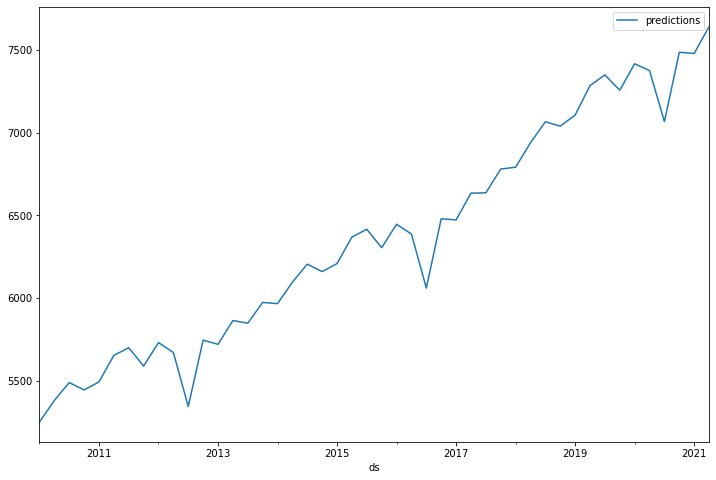

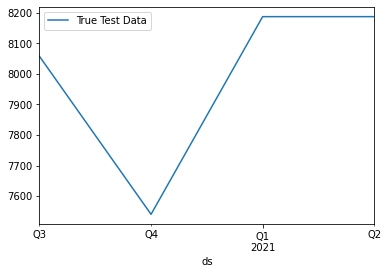

In [152]:
forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data')

MAE: 173.467
MSE: 273.163


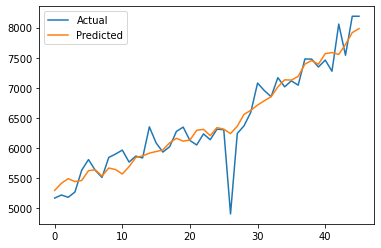

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

y_true = df_00100['y'].values
y_pred = forecast['yhat'][:46].values
mae = mean_absolute_error(y_true, y_pred)
mse = math.sqrt(mean_squared_error(y_true, y_pred))

print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)

# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

#### MAE and RMSE for each postal code

In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mae_values = []
rmse_values = []

for pc in postal_codes:
    print(pc)
    pc_df = df[[pc, "time"]].rename(columns={pc:"y","time":"ds"})
    prop = Prophet(interval_width=0.95)
    prop.fit(pc_df)
    forecast = prop.predict(old_dates)
    mae = mean_absolute_error(pc_df["y"], forecast["yhat"])
    rmse = math.sqrt(mean_squared_error(pc_df["y"], forecast["yhat"]))
    mae_values.append(mae)
    rmse_values.append(rmse)

data = pd.DataFrame({"postal code":postal_codes, "rmse":rmse_values, "mae":mae_values })


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00100

Initial log joint probability = -56.5006
Iteration  1. Log joint probability =    64.4408. Improved by 120.941.
Iteration  2. Log joint probability =    93.9887. Improved by 29.5479.
Iteration  3. Log joint probability =    110.688. Improved by 16.6991.
Iteration  4. Log joint probability =    122.382. Improved by 11.6938.
Iteration  5. Log joint probability =    125.432. Improved by 3.05013.
Iteration  6. Log joint probability =    125.445. Improved by 0.013562.
Iteration  7. Log joint probability =    125.604. Improved by 0.158237.
Iteration  8. Log joint probability =    125.653. Improved by 0.0497161.
Iteration  9. Log joint probability =    125.678. Improved by 0.0246621.
Iteration 10. Log joint probability =    125.721. Improved by 0.0428701.
Iteration 11. Log joint probability =    125.797. Improved by 0.0758697.
Iteration 12. Log joint probability =    125.834. Improved by 0.0376473.
Iteration 13. Log joint probability =    125.843. Improved by 0.00888646.
Iteration 14. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00260

Initial log joint probability = -56.4948
Iteration  1. Log joint probability =    64.3849. Improved by 120.88.
Iteration  2. Log joint probability =    85.1871. Improved by 20.8021.
Iteration  3. Log joint probability =     96.085. Improved by 10.898.
Iteration  4. Log joint probability =    104.803. Improved by 8.71772.
Iteration  5. Log joint probability =    115.847. Improved by 11.0442.
Iteration  6. Log joint probability =    115.951. Improved by 0.103722.
Iteration  7. Log joint probability =    116.382. Improved by 0.430943.
Iteration  8. Log joint probability =    116.613. Improved by 0.230999.
Iteration  9. Log joint probability =    116.789. Improved by 0.176461.
Iteration 10. Log joint probability =    117.165. Improved by 0.375818.
Iteration 11. Log joint probability =    117.311. Improved by 0.146126.
Iteration 12. Log joint probability =    117.894. Improved by 0.583065.
Iteration 13. Log joint probability =     118.17. Improved by 0.276147.
Iteration 14. Log joint

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00360

Initial log joint probability = -56.4844
Iteration  1. Log joint probability =    65.2826. Improved by 121.767.
Iteration  2. Log joint probability =    93.2029. Improved by 27.9204.
Iteration  3. Log joint probability =    113.331. Improved by 20.1284.
Iteration  4. Log joint probability =    130.071. Improved by 16.7396.
Iteration  5. Log joint probability =    133.829. Improved by 3.75765.
Iteration  6. Log joint probability =    133.895. Improved by 0.0664482.
Iteration  7. Log joint probability =    133.961. Improved by 0.0658328.
Iteration  8. Log joint probability =    134.022. Improved by 0.0610048.
Iteration  9. Log joint probability =    134.099. Improved by 0.0766633.
Iteration 10. Log joint probability =    134.139. Improved by 0.0401531.
Iteration 11. Log joint probability =    134.206. Improved by 0.0668014.
Iteration 12. Log joint probability =    134.222. Improved by 0.0166991.
Iteration 13. Log joint probability =    134.267. Improved by 0.0444234.
Iteration 14.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00500

Initial log joint probability = -56.446
Iteration  1. Log joint probability =    29.0886. Improved by 85.5346.
Iteration  2. Log joint probability =    131.279. Improved by 102.19.
Iteration  3. Log joint probability =    152.921. Improved by 21.6419.
Iteration  4. Log joint probability =    156.546. Improved by 3.62504.
Iteration  5. Log joint probability =    156.641. Improved by 0.0957854.
Iteration  6. Log joint probability =    156.664. Improved by 0.0223762.
Iteration  7. Log joint probability =    156.697. Improved by 0.0329829.
Iteration  8. Log joint probability =     156.81. Improved by 0.113265.
Iteration  9. Log joint probability =    156.814. Improved by 0.00399663.
Iteration 10. Log joint probability =    157.077. Improved by 0.263127.
Iteration 11. Log joint probability =    157.163. Improved by 0.0857495.
Iteration 12. Log joint probability =    157.525. Improved by 0.361863.
Iteration 13. Log joint probability =    157.769. Improved by 0.244467.
Iteration 14. Lo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00520

Initial log joint probability = -56.4833
Iteration  1. Log joint probability =    65.2165. Improved by 121.7.
Iteration  2. Log joint probability =    94.5092. Improved by 29.2927.
Iteration  3. Log joint probability =    96.4533. Improved by 1.94404.
Iteration  4. Log joint probability =    125.327. Improved by 28.8737.
Iteration  5. Log joint probability =     139.61. Improved by 14.2831.
Iteration  6. Log joint probability =    141.149. Improved by 1.53849.
Iteration  7. Log joint probability =    141.341. Improved by 0.192206.
Iteration  8. Log joint probability =     141.36. Improved by 0.0197084.
Iteration  9. Log joint probability =    141.394. Improved by 0.0336442.
Iteration 10. Log joint probability =    141.448. Improved by 0.0537865.
Iteration 11. Log joint probability =    141.697. Improved by 0.248987.
Iteration 12. Log joint probability =    141.927. Improved by 0.22969.
Iteration 13. Log joint probability =    141.943. Improved by 0.0161042.
Iteration 14. Log joi

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00730

Initial log joint probability = -56.5909
Iteration  1. Log joint probability =    58.7314. Improved by 115.322.
Iteration  2. Log joint probability =    86.0885. Improved by 27.3571.
Iteration  3. Log joint probability =    105.961. Improved by 19.8723.
Iteration  4. Log joint probability =    109.245. Improved by 3.28412.
Iteration  5. Log joint probability =     109.67. Improved by 0.425614.
Iteration  6. Log joint probability =    109.674. Improved by 0.00367958.
Iteration  7. Log joint probability =    109.684. Improved by 0.00988855.
Iteration  8. Log joint probability =    109.704. Improved by 0.0203169.
Iteration  9. Log joint probability =    109.788. Improved by 0.084078.
Iteration 10. Log joint probability =    110.299. Improved by 0.510153.
Iteration 11. Log joint probability =    110.311. Improved by 0.0119397.
Iteration 12. Log joint probability =    110.534. Improved by 0.22357.
Iteration 13. Log joint probability =     110.54. Improved by 0.00574891.
Iteration 14.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


00820

Initial log joint probability = -56.6688
Iteration  1. Log joint probability =    40.8226. Improved by 97.4914.
Iteration  2. Log joint probability =    86.2379. Improved by 45.4153.
Iteration  3. Log joint probability =    104.529. Improved by 18.291.
Iteration  4. Log joint probability =    122.812. Improved by 18.283.
Iteration  5. Log joint probability =    126.535. Improved by 3.72305.
Iteration  6. Log joint probability =    126.605. Improved by 0.0701348.
Iteration  7. Log joint probability =     126.63. Improved by 0.0246236.
Iteration  8. Log joint probability =    126.672. Improved by 0.0422864.
Iteration  9. Log joint probability =    126.772. Improved by 0.099757.
Iteration 10. Log joint probability =    126.819. Improved by 0.0469372.
Iteration 11. Log joint probability =    127.007. Improved by 0.188321.
Iteration 12. Log joint probability =    127.076. Improved by 0.0693116.
Iteration 13. Log joint probability =     127.29. Improved by 0.213206.
Iteration 14. Log 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


01280

Initial log joint probability = -56.5121
Iteration  1. Log joint probability =    64.1967. Improved by 120.709.
Iteration  2. Log joint probability =    91.1506. Improved by 26.9539.
Iteration  3. Log joint probability =    112.922. Improved by 21.7719.
Iteration  4. Log joint probability =    114.548. Improved by 1.626.
Iteration  5. Log joint probability =    119.659. Improved by 5.11093.
Iteration  6. Log joint probability =    119.717. Improved by 0.0579551.
Iteration  7. Log joint probability =    119.737. Improved by 0.0199931.
Iteration  8. Log joint probability =     119.75. Improved by 0.0130966.
Iteration  9. Log joint probability =    119.797. Improved by 0.0468545.
Iteration 10. Log joint probability =    119.806. Improved by 0.0091642.
Iteration 11. Log joint probability =    119.892. Improved by 0.0853668.
Iteration 12. Log joint probability =    119.971. Improved by 0.0795279.
Iteration 13. Log joint probability =     120.05. Improved by 0.0790096.
Iteration 14. L

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


01300

Initial log joint probability = -56.4716
Iteration  1. Log joint probability =    66.1344. Improved by 122.606.
Iteration  2. Log joint probability =    98.8523. Improved by 32.7179.
Iteration  3. Log joint probability =    118.115. Improved by 19.2629.
Iteration  4. Log joint probability =    129.918. Improved by 11.8028.
Iteration  5. Log joint probability =    133.072. Improved by 3.15437.
Iteration  6. Log joint probability =     133.18. Improved by 0.108084.
Iteration  7. Log joint probability =    133.335. Improved by 0.154853.
Iteration  8. Log joint probability =    133.688. Improved by 0.352388.
Iteration  9. Log joint probability =    133.924. Improved by 0.236363.
Iteration 10. Log joint probability =     134.07. Improved by 0.145791.
Iteration 11. Log joint probability =    134.152. Improved by 0.0825545.
Iteration 12. Log joint probability =    134.334. Improved by 0.181679.
Iteration 13. Log joint probability =    134.341. Improved by 0.00717414.
Iteration 14. Log 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


01450

Initial log joint probability = -56.6746
Iteration  1. Log joint probability =    43.8264. Improved by 100.501.
Iteration  2. Log joint probability =     81.722. Improved by 37.8956.
Iteration  3. Log joint probability =     103.18. Improved by 21.458.
Iteration  4. Log joint probability =    103.235. Improved by 0.0552442.
Iteration  5. Log joint probability =    103.386. Improved by 0.151229.
Iteration  6. Log joint probability =    103.392. Improved by 0.00537155.
Iteration  7. Log joint probability =     103.55. Improved by 0.157901.
Iteration  8. Log joint probability =    103.653. Improved by 0.103626.
Iteration  9. Log joint probability =     103.67. Improved by 0.0163872.
Iteration 10. Log joint probability =    115.943. Improved by 12.2733.
Iteration 11. Log joint probability =    116.604. Improved by 0.660977.
Iteration 12. Log joint probability =    116.677. Improved by 0.0735305.
Iteration 13. Log joint probability =     116.74. Improved by 0.0628843.
Iteration 14. L

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


02200

Initial log joint probability = -56.509
Iteration  1. Log joint probability =    63.6589. Improved by 120.168.
Iteration  2. Log joint probability =    77.6435. Improved by 13.9846.
Iteration  3. Log joint probability =    89.1984. Improved by 11.5548.
Iteration  4. Log joint probability =    108.449. Improved by 19.2502.
Iteration  5. Log joint probability =    114.249. Improved by 5.80081.
Iteration  6. Log joint probability =    114.286. Improved by 0.0364736.
Iteration  7. Log joint probability =    114.319. Improved by 0.0335661.
Iteration  8. Log joint probability =    114.428. Improved by 0.108021.
Iteration  9. Log joint probability =    114.432. Improved by 0.00471712.
Iteration 10. Log joint probability =    114.534. Improved by 0.101317.
Iteration 11. Log joint probability =    114.594. Improved by 0.0606963.
Iteration 12. Log joint probability =    114.605. Improved by 0.0108865.
Iteration 13. Log joint probability =    119.168. Improved by 4.56285.
Iteration 14. Log

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


02210

Initial log joint probability = -56.4575
Iteration  1. Log joint probability =    51.3158. Improved by 107.773.
Iteration  2. Log joint probability =    115.959. Improved by 64.6434.
Iteration  3. Log joint probability =    132.323. Improved by 16.364.
Iteration  4. Log joint probability =    141.133. Improved by 8.80985.
Iteration  5. Log joint probability =    141.142. Improved by 0.00914443.
Iteration  6. Log joint probability =     141.34. Improved by 0.197285.
Iteration  7. Log joint probability =    141.371. Improved by 0.0314104.
Iteration  8. Log joint probability =    141.505. Improved by 0.133695.
Iteration  9. Log joint probability =    141.615. Improved by 0.110064.
Iteration 10. Log joint probability =    141.698. Improved by 0.0830944.
Iteration 11. Log joint probability =    141.742. Improved by 0.0445245.
Iteration 12. Log joint probability =    141.753. Improved by 0.0110885.
Iteration 13. Log joint probability =    141.836. Improved by 0.0823443.
Iteration 14. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


02320

Initial log joint probability = -56.4777
Iteration  1. Log joint probability =    65.9457. Improved by 122.423.
Iteration  2. Log joint probability =    99.3587. Improved by 33.413.
Iteration  3. Log joint probability =     120.19. Improved by 20.8313.
Iteration  4. Log joint probability =    132.194. Improved by 12.0041.
Iteration  5. Log joint probability =    132.558. Improved by 0.363593.
Iteration  6. Log joint probability =    133.198. Improved by 0.639861.
Iteration  7. Log joint probability =     133.24. Improved by 0.0420574.
Iteration  8. Log joint probability =    133.299. Improved by 0.0589338.
Iteration  9. Log joint probability =     133.34. Improved by 0.0418866.
Iteration 10. Log joint probability =    133.419. Improved by 0.0783299.
Iteration 11. Log joint probability =    133.618. Improved by 0.199704.
Iteration 12. Log joint probability =    133.856. Improved by 0.237805.
Iteration 13. Log joint probability =    133.913. Improved by 0.0569612.
Iteration 14. Lo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


02400

Initial log joint probability = -56.5503
Iteration  1. Log joint probability =     62.641. Improved by 119.191.
Iteration  2. Log joint probability =    76.0361. Improved by 13.3951.
Iteration  3. Log joint probability =    94.3304. Improved by 18.2943.
Iteration  4. Log joint probability =    102.804. Improved by 8.47398.
Iteration  5. Log joint probability =     102.81. Improved by 0.00532284.
Iteration  6. Log joint probability =    102.839. Improved by 0.0295287.
Iteration  7. Log joint probability =    102.961. Improved by 0.12159.
Iteration  8. Log joint probability =    103.256. Improved by 0.295298.
Iteration  9. Log joint probability =    103.304. Improved by 0.0481575.
Iteration 10. Log joint probability =    103.327. Improved by 0.0222784.
Iteration 11. Log joint probability =    103.621. Improved by 0.294839.
Iteration 12. Log joint probability =    104.167. Improved by 0.545607.
Iteration 13. Log joint probability =     105.07. Improved by 0.902708.
Iteration 14. Lo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


02760

Initial log joint probability = -56.5449
Iteration  1. Log joint probability =    60.8373. Improved by 117.382.
Iteration  2. Log joint probability =    72.2453. Improved by 11.408.
Iteration  3. Log joint probability =    92.1486. Improved by 19.9033.
Iteration  4. Log joint probability =    113.376. Improved by 21.2271.
Iteration  5. Log joint probability =    115.426. Improved by 2.04981.
Iteration  6. Log joint probability =    119.093. Improved by 3.66787.
Iteration  7. Log joint probability =    119.097. Improved by 0.00359671.
Iteration  8. Log joint probability =    119.121. Improved by 0.0236749.
Iteration  9. Log joint probability =    119.259. Improved by 0.138141.
Iteration 10. Log joint probability =     119.36. Improved by 0.101639.
Iteration 11. Log joint probability =    119.576. Improved by 0.215585.
Iteration 12. Log joint probability =    119.653. Improved by 0.0772871.
Iteration 13. Log joint probability =    119.676. Improved by 0.0227832.
Iteration 14. Log 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


03100

Initial log joint probability = -56.6749
Iteration  1. Log joint probability =    52.4404. Improved by 109.115.
Iteration  2. Log joint probability =    77.4594. Improved by 25.0191.
Iteration  3. Log joint probability =    101.434. Improved by 23.9744.
Iteration  4. Log joint probability =     102.58. Improved by 1.14648.
Iteration  5. Log joint probability =    102.622. Improved by 0.0416788.
Iteration  6. Log joint probability =    102.702. Improved by 0.0797284.
Iteration  7. Log joint probability =    102.722. Improved by 0.0203498.
Iteration  8. Log joint probability =    102.725. Improved by 0.00294323.
Iteration  9. Log joint probability =     102.73. Improved by 0.0053469.
Iteration 10. Log joint probability =    102.731. Improved by 0.00112161.
Iteration 11. Log joint probability =    102.733. Improved by 0.00148034.
Iteration 12. Log joint probability =    102.734. Improved by 0.00090451.
Iteration 13. Log joint probability =    102.735. Improved by 0.000991762.
Itera

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


04410

Initial log joint probability = -56.84
Iteration  1. Log joint probability =    7.55759. Improved by 64.3975.
Iteration  2. Log joint probability =    23.3755. Improved by 15.818.
Iteration  3. Log joint probability =    23.4158. Improved by 0.0403019.
Iteration  4. Log joint probability =    23.4195. Improved by 0.0036645.
Iteration  5. Log joint probability =    23.4925. Improved by 0.0730031.
Iteration  6. Log joint probability =    23.6324. Improved by 0.139871.
Iteration  7. Log joint probability =    23.6671. Improved by 0.0346695.
Iteration  8. Log joint probability =    23.7979. Improved by 0.130883.
Iteration  9. Log joint probability =    23.8394. Improved by 0.0414844.
Iteration 10. Log joint probability =    24.0573. Improved by 0.217889.
Iteration 11. Log joint probability =    24.3447. Improved by 0.28739.
Iteration 12. Log joint probability =    24.3744. Improved by 0.0297482.
Iteration 13. Log joint probability =    24.7429. Improved by 0.368479.
Iteration 14. Lo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


06100

Initial log joint probability = -56.5542
Iteration  1. Log joint probability =    59.4339. Improved by 115.988.
Iteration  2. Log joint probability =    59.4541. Improved by 0.0201258.
Iteration  3. Log joint probability =    112.179. Improved by 52.7246.
Iteration  4. Log joint probability =    112.224. Improved by 0.0454369.
Iteration  5. Log joint probability =    112.364. Improved by 0.139385.
Iteration  6. Log joint probability =    112.446. Improved by 0.0824145.
Iteration  7. Log joint probability =    112.448. Improved by 0.00216766.
Iteration  8. Log joint probability =    112.449. Improved by 0.000512315.
Iteration  9. Log joint probability =    112.463. Improved by 0.0148272.
Iteration 10. Log joint probability =    112.523. Improved by 0.0594317.
Iteration 11. Log joint probability =    123.731. Improved by 11.2078.
Iteration 12. Log joint probability =    123.767. Improved by 0.0359964.
Iteration 13. Log joint probability =    124.403. Improved by 0.636484.
Iteratio

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20100

Initial log joint probability = -56.4701
Iteration  1. Log joint probability =         66. Improved by 122.47.
Iteration  2. Log joint probability =    96.8852. Improved by 30.8852.
Iteration  3. Log joint probability =    122.479. Improved by 25.594.
Iteration  4. Log joint probability =    137.293. Improved by 14.814.
Iteration  5. Log joint probability =    152.483. Improved by 15.1896.
Iteration  6. Log joint probability =    152.805. Improved by 0.32176.
Iteration  7. Log joint probability =    155.239. Improved by 2.43415.
Iteration  8. Log joint probability =    157.322. Improved by 2.08286.
Iteration  9. Log joint probability =    159.438. Improved by 2.11599.
Iteration 10. Log joint probability =    159.749. Improved by 0.311775.
Iteration 11. Log joint probability =    159.952. Improved by 0.202557.
Iteration 12. Log joint probability =     160.77. Improved by 0.817762.
Iteration 13. Log joint probability =    160.822. Improved by 0.0519166.
Iteration 14. Log joint pro

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20320

Initial log joint probability = -56.5964
Iteration  1. Log joint probability =    52.0618. Improved by 108.658.
Iteration  2. Log joint probability =    84.4991. Improved by 32.4373.
Iteration  3. Log joint probability =    111.635. Improved by 27.1355.
Iteration  4. Log joint probability =    134.439. Improved by 22.804.
Iteration  5. Log joint probability =    140.583. Improved by 6.14451.
Iteration  6. Log joint probability =    140.612. Improved by 0.0290776.
Iteration  7. Log joint probability =    140.704. Improved by 0.0914508.
Iteration  8. Log joint probability =    140.739. Improved by 0.0355401.
Iteration  9. Log joint probability =    141.227. Improved by 0.488259.
Iteration 10. Log joint probability =    141.424. Improved by 0.196421.
Iteration 11. Log joint probability =    141.457. Improved by 0.0331755.
Iteration 12. Log joint probability =    141.589. Improved by 0.132125.
Iteration 13. Log joint probability =    141.693. Improved by 0.10426.
Iteration 14. Log j

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20540

Initial log joint probability = -56.5561
Iteration  1. Log joint probability =    59.8604. Improved by 116.416.
Iteration  2. Log joint probability =    87.8281. Improved by 27.9678.
Iteration  3. Log joint probability =     114.37. Improved by 26.5415.
Iteration  4. Log joint probability =    122.695. Improved by 8.32502.
Iteration  5. Log joint probability =    124.656. Improved by 1.9614.
Iteration  6. Log joint probability =    124.732. Improved by 0.0763977.
Iteration  7. Log joint probability =    124.804. Improved by 0.0717901.
Iteration  8. Log joint probability =     124.83. Improved by 0.0256483.
Iteration  9. Log joint probability =    125.109. Improved by 0.279198.
Iteration 10. Log joint probability =    125.227. Improved by 0.118147.
Iteration 11. Log joint probability =    125.645. Improved by 0.417882.
Iteration 12. Log joint probability =    125.777. Improved by 0.131491.
Iteration 13. Log joint probability =    125.833. Improved by 0.0564506.
Iteration 14. Log 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20780

Initial log joint probability = -56.6097
Iteration  1. Log joint probability =    56.8287. Improved by 113.438.
Iteration  2. Log joint probability =    83.5504. Improved by 26.7217.
Iteration  3. Log joint probability =      104.8. Improved by 21.2498.
Iteration  4. Log joint probability =    106.915. Improved by 2.1147.
Iteration  5. Log joint probability =    109.036. Improved by 2.12144.
Iteration  6. Log joint probability =    109.048. Improved by 0.0112439.
Iteration  7. Log joint probability =    109.055. Improved by 0.00703888.
Iteration  8. Log joint probability =    109.065. Improved by 0.00991805.
Iteration  9. Log joint probability =    109.084. Improved by 0.0197041.
Iteration 10. Log joint probability =    109.102. Improved by 0.0174805.
Iteration 11. Log joint probability =    109.126. Improved by 0.0242875.
Iteration 12. Log joint probability =    109.284. Improved by 0.158272.
Iteration 13. Log joint probability =    109.318. Improved by 0.0335252.
Iteration 14.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20810

Initial log joint probability = -56.5586
Iteration  1. Log joint probability =    58.3936. Improved by 114.952.
Iteration  2. Log joint probability =    85.1474. Improved by 26.7538.
Iteration  3. Log joint probability =    115.017. Improved by 29.8692.
Iteration  4. Log joint probability =    117.149. Improved by 2.13236.
Iteration  5. Log joint probability =    133.163. Improved by 16.0144.
Iteration  6. Log joint probability =     133.31. Improved by 0.146303.
Iteration  7. Log joint probability =    133.364. Improved by 0.0540439.
Iteration  8. Log joint probability =    133.407. Improved by 0.0437559.
Iteration  9. Log joint probability =    133.579. Improved by 0.171296.
Iteration 10. Log joint probability =    133.719. Improved by 0.140328.
Iteration 11. Log joint probability =    133.844. Improved by 0.125254.
Iteration 12. Log joint probability =    133.857. Improved by 0.0127644.
Iteration 13. Log joint probability =    134.164. Improved by 0.306726.
Iteration 14. Log 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21200

Initial log joint probability = -56.6043
Iteration  1. Log joint probability =    53.7707. Improved by 110.375.
Iteration  2. Log joint probability =    78.6341. Improved by 24.8634.
Iteration  3. Log joint probability =    104.576. Improved by 25.9422.
Iteration  4. Log joint probability =    104.661. Improved by 0.0843162.
Iteration  5. Log joint probability =    119.666. Improved by 15.0054.
Iteration  6. Log joint probability =    123.642. Improved by 3.97654.
Iteration  7. Log joint probability =    124.274. Improved by 0.631536.
Iteration  8. Log joint probability =    124.333. Improved by 0.0590692.
Iteration  9. Log joint probability =    124.659. Improved by 0.326203.
Iteration 10. Log joint probability =      125.8. Improved by 1.14034.
Iteration 11. Log joint probability =    125.898. Improved by 0.0981136.
Iteration 12. Log joint probability =    126.023. Improved by 0.125557.
Iteration 13. Log joint probability =    126.209. Improved by 0.185943.
Iteration 14. Log j

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23500

Initial log joint probability = -56.532
Iteration  1. Log joint probability =  0.0456028. Improved by 56.5777.
Iteration  2. Log joint probability =    67.7541. Improved by 67.7085.
Iteration  3. Log joint probability =    88.3128. Improved by 20.5587.
Iteration  4. Log joint probability =    88.3314. Improved by 0.0186249.
Iteration  5. Log joint probability =    88.3472. Improved by 0.0157476.
Iteration  6. Log joint probability =    88.4284. Improved by 0.0812264.
Iteration  7. Log joint probability =    88.6162. Improved by 0.18778.
Iteration  8. Log joint probability =      88.84. Improved by 0.223769.
Iteration  9. Log joint probability =    88.8874. Improved by 0.0474329.
Iteration 10. Log joint probability =    88.9164. Improved by 0.0290535.
Iteration 11. Log joint probability =    89.0961. Improved by 0.179675.
Iteration 12. Log joint probability =    89.1005. Improved by 0.00435961.
Iteration 13. Log joint probability =    89.1397. Improved by 0.0392653.
Iteration 14.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24100

Initial log joint probability = -56.5339
Iteration  1. Log joint probability =    62.9655. Improved by 119.499.
Iteration  2. Log joint probability =    89.1828. Improved by 26.2173.
Iteration  3. Log joint probability =    109.618. Improved by 20.4348.
Iteration  4. Log joint probability =    116.693. Improved by 7.07534.
Iteration  5. Log joint probability =    117.534. Improved by 0.841406.
Iteration  6. Log joint probability =    117.543. Improved by 0.00866034.
Iteration  7. Log joint probability =    117.547. Improved by 0.00430996.
Iteration  8. Log joint probability =    117.557. Improved by 0.00979773.
Iteration  9. Log joint probability =     117.56. Improved by 0.00243079.
Iteration 10. Log joint probability =     117.65. Improved by 0.0907389.
Iteration 11. Log joint probability =    117.853. Improved by 0.202742.
Iteration 12. Log joint probability =    118.052. Improved by 0.198564.
Iteration 13. Log joint probability =    118.115. Improved by 0.0637201.
Iteration 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26100

Initial log joint probability = -56.6183
Iteration  1. Log joint probability =     58.459. Improved by 115.077.
Iteration  2. Log joint probability =    81.0314. Improved by 22.5724.
Iteration  3. Log joint probability =    98.8555. Improved by 17.824.
Iteration  4. Log joint probability =    100.313. Improved by 1.4579.
Iteration  5. Log joint probability =    100.465. Improved by 0.152034.
Iteration  6. Log joint probability =    100.491. Improved by 0.026073.
Iteration  7. Log joint probability =    100.676. Improved by 0.184947.
Iteration  8. Log joint probability =    100.741. Improved by 0.0649523.
Iteration  9. Log joint probability =    100.819. Improved by 0.0773218.
Iteration 10. Log joint probability =    100.857. Improved by 0.0384814.
Iteration 11. Log joint probability =    100.871. Improved by 0.0133255.
Iteration 12. Log joint probability =    100.888. Improved by 0.0173547.
Iteration 13. Log joint probability =     100.92. Improved by 0.0317314.
Iteration 14. Lo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33200

Initial log joint probability = -56.5274
Iteration  1. Log joint probability =    61.6423. Improved by 118.17.
Iteration  2. Log joint probability =    89.8862. Improved by 28.2439.
Iteration  3. Log joint probability =    120.256. Improved by 30.3698.
Iteration  4. Log joint probability =    135.158. Improved by 14.9016.
Iteration  5. Log joint probability =    137.414. Improved by 2.25647.
Iteration  6. Log joint probability =    137.431. Improved by 0.016861.
Iteration  7. Log joint probability =    137.463. Improved by 0.0321533.
Iteration  8. Log joint probability =    137.496. Improved by 0.0329754.
Iteration  9. Log joint probability =    137.617. Improved by 0.120513.
Iteration 10. Log joint probability =    137.624. Improved by 0.00742366.
Iteration 11. Log joint probability =    137.765. Improved by 0.140573.
Iteration 12. Log joint probability =    137.883. Improved by 0.118479.
Iteration 13. Log joint probability =    138.207. Improved by 0.32344.
Iteration 14. Log j

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33560

Initial log joint probability = -56.5003
Iteration  1. Log joint probability =    64.7175. Improved by 121.218.
Iteration  2. Log joint probability =    92.0357. Improved by 27.3182.
Iteration  3. Log joint probability =    106.174. Improved by 14.1383.
Iteration  4. Log joint probability =    116.969. Improved by 10.7947.
Iteration  5. Log joint probability =    122.736. Improved by 5.76725.
Iteration  6. Log joint probability =    123.079. Improved by 0.342642.
Iteration  7. Log joint probability =    123.161. Improved by 0.0820634.
Iteration  8. Log joint probability =    123.249. Improved by 0.0884667.
Iteration  9. Log joint probability =    123.269. Improved by 0.019485.
Iteration 10. Log joint probability =    123.301. Improved by 0.0324298.
Iteration 11. Log joint probability =    123.306. Improved by 0.00459735.
Iteration 12. Log joint probability =    123.415. Improved by 0.109548.
Iteration 13. Log joint probability =    123.484. Improved by 0.0690264.
Iteration 14. L

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33580

Initial log joint probability = -56.5327
Iteration  1. Log joint probability =    61.4512. Improved by 117.984.
Iteration  2. Log joint probability =    86.9318. Improved by 25.4806.
Iteration  3. Log joint probability =    91.9837. Improved by 5.05188.
Iteration  4. Log joint probability =    103.309. Improved by 11.3256.
Iteration  5. Log joint probability =    113.227. Improved by 9.91776.
Iteration  6. Log joint probability =    113.303. Improved by 0.0757337.
Iteration  7. Log joint probability =    113.425. Improved by 0.12263.
Iteration  8. Log joint probability =    113.476. Improved by 0.0509442.
Iteration  9. Log joint probability =    113.669. Improved by 0.193077.
Iteration 10. Log joint probability =    113.753. Improved by 0.0835548.
Iteration 11. Log joint probability =    113.913. Improved by 0.159788.
Iteration 12. Log joint probability =     114.31. Improved by 0.397315.
Iteration 13. Log joint probability =    114.351. Improved by 0.0411092.
Iteration 14. Log 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33710

Initial log joint probability = -56.5175
Iteration  1. Log joint probability =     62.692. Improved by 119.209.
Iteration  2. Log joint probability =    90.1922. Improved by 27.5003.
Iteration  3. Log joint probability =    112.646. Improved by 22.4542.
Iteration  4. Log joint probability =    132.613. Improved by 19.9666.
Iteration  5. Log joint probability =    137.054. Improved by 4.44126.
Iteration  6. Log joint probability =    137.063. Improved by 0.00835536.
Iteration  7. Log joint probability =    137.128. Improved by 0.0653246.
Iteration  8. Log joint probability =     137.25. Improved by 0.122093.
Iteration  9. Log joint probability =    137.373. Improved by 0.123203.
Iteration 10. Log joint probability =      137.6. Improved by 0.226785.
Iteration 11. Log joint probability =    137.706. Improved by 0.106402.
Iteration 12. Log joint probability =    138.019. Improved by 0.312095.
Iteration 13. Log joint probability =    138.086. Improved by 0.0671319.
Iteration 14. Log

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33820

Initial log joint probability = -56.5008
Iteration  1. Log joint probability =    7.73243. Improved by 64.2333.
Iteration  2. Log joint probability =    62.4729. Improved by 54.7405.
Iteration  3. Log joint probability =     91.765. Improved by 29.2921.
Iteration  4. Log joint probability =    91.8517. Improved by 0.0866454.
Iteration  5. Log joint probability =    91.8603. Improved by 0.00866106.
Iteration  6. Log joint probability =    91.8818. Improved by 0.0214561.
Iteration  7. Log joint probability =    91.8828. Improved by 0.0010038.
Iteration  8. Log joint probability =    91.9027. Improved by 0.0199334.
Iteration  9. Log joint probability =    91.9433. Improved by 0.0405401.
Iteration 10. Log joint probability =    91.9976. Improved by 0.0543412.
Iteration 11. Log joint probability =    92.0571. Improved by 0.059491.
Iteration 12. Log joint probability =    92.1914. Improved by 0.13431.
Iteration 13. Log joint probability =    92.5854. Improved by 0.393977.
Iteration 14

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33850

Initial log joint probability = -56.6107
Iteration  1. Log joint probability =    56.1078. Improved by 112.718.
Iteration  2. Log joint probability =    81.0541. Improved by 24.9463.
Iteration  3. Log joint probability =    101.557. Improved by 20.5025.
Iteration  4. Log joint probability =    111.617. Improved by 10.0605.
Iteration  5. Log joint probability =    113.608. Improved by 1.99111.
Iteration  6. Log joint probability =    113.802. Improved by 0.19368.
Iteration  7. Log joint probability =    113.968. Improved by 0.16651.
Iteration  8. Log joint probability =    113.985. Improved by 0.0167566.
Iteration  9. Log joint probability =    114.015. Improved by 0.0294415.
Iteration 10. Log joint probability =    114.028. Improved by 0.0132452.
Iteration 11. Log joint probability =    114.064. Improved by 0.0362199.
Iteration 12. Log joint probability =      114.1. Improved by 0.0355388.
Iteration 13. Log joint probability =    114.177. Improved by 0.0771053.
Iteration 14. Log

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33960

Initial log joint probability = -56.5721
Iteration  1. Log joint probability =    61.2155. Improved by 117.788.
Iteration  2. Log joint probability =     86.455. Improved by 25.2396.
Iteration  3. Log joint probability =     86.803. Improved by 0.34794.
Iteration  4. Log joint probability =    89.9418. Improved by 3.13886.
Iteration  5. Log joint probability =    89.9502. Improved by 0.00834707.
Iteration  6. Log joint probability =    89.9776. Improved by 0.0274472.
Iteration  7. Log joint probability =    90.0021. Improved by 0.0244664.
Iteration  8. Log joint probability =    91.5626. Improved by 1.56052.
Iteration  9. Log joint probability =    91.8081. Improved by 0.245493.
Iteration 10. Log joint probability =    91.9135. Improved by 0.105387.
Iteration 11. Log joint probability =    92.0196. Improved by 0.106103.
Iteration 12. Log joint probability =    92.0833. Improved by 0.0637431.
Iteration 13. Log joint probability =    92.1736. Improved by 0.090227.
Iteration 14. Lo

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36200

Initial log joint probability = -56.9978
Iteration  1. Log joint probability =    37.8191. Improved by 94.8169.
Iteration  2. Log joint probability =    69.4853. Improved by 31.6663.
Iteration  3. Log joint probability =    77.7627. Improved by 8.27737.
Iteration  4. Log joint probability =    82.9291. Improved by 5.16638.
Iteration  5. Log joint probability =    95.6177. Improved by 12.6886.
Iteration  6. Log joint probability =    95.6839. Improved by 0.06617.
Iteration  7. Log joint probability =    96.1973. Improved by 0.5134.
Iteration  8. Log joint probability =    96.3444. Improved by 0.147155.
Iteration  9. Log joint probability =    96.4578. Improved by 0.113406.
Iteration 10. Log joint probability =    96.4856. Improved by 0.027774.
Iteration 11. Log joint probability =    96.6137. Improved by 0.128068.
Iteration 12. Log joint probability =    96.6283. Improved by 0.0146371.
Iteration 13. Log joint probability =    96.6398. Improved by 0.0115225.
Iteration 14. Log join

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


37120

Initial log joint probability = -56.6186
Iteration  1. Log joint probability =    59.6556. Improved by 116.274.
Iteration  2. Log joint probability =    81.9873. Improved by 22.3317.
Iteration  3. Log joint probability =    87.9469. Improved by 5.95957.
Iteration  4. Log joint probability =    93.6151. Improved by 5.6682.
Iteration  5. Log joint probability =    93.6452. Improved by 0.0300964.
Iteration  6. Log joint probability =    93.6454. Improved by 0.000240068.
Iteration  7. Log joint probability =    93.6455. Improved by 5.41559e-05.
Iteration  8. Log joint probability =     93.652. Improved by 0.00652981.
Iteration  9. Log joint probability =    93.7191. Improved by 0.0670757.
Iteration 10. Log joint probability =    93.7327. Improved by 0.0135824.
Iteration 11. Log joint probability =    94.2192. Improved by 0.486479.
Iteration 12. Log joint probability =    94.2498. Improved by 0.0306599.
Iteration 13. Log joint probability =    94.2553. Improved by 0.0055077.
Iteratio

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40520

Initial log joint probability = -56.6464
Iteration  1. Log joint probability =    49.0947. Improved by 105.741.
Iteration  2. Log joint probability =    80.8666. Improved by 31.7719.
Iteration  3. Log joint probability =    100.627. Improved by 19.7603.
Iteration  4. Log joint probability =     115.68. Improved by 15.0531.
Iteration  5. Log joint probability =    116.711. Improved by 1.03126.
Iteration  6. Log joint probability =    117.063. Improved by 0.351845.
Iteration  7. Log joint probability =    117.155. Improved by 0.0921804.
Iteration  8. Log joint probability =    117.276. Improved by 0.120544.
Iteration  9. Log joint probability =    117.402. Improved by 0.126174.
Iteration 10. Log joint probability =    117.433. Improved by 0.0314367.
Iteration 11. Log joint probability =    117.445. Improved by 0.0120499.
Iteration 12. Log joint probability =    117.749. Improved by 0.303651.
Iteration 13. Log joint probability =     117.93. Improved by 0.181376.
Iteration 14. Log 

array([<AxesSubplot:title={'center':'rmse'}, xlabel='postal code'>,
       <AxesSubplot:title={'center':'mae'}, xlabel='postal code'>],
      dtype=object)

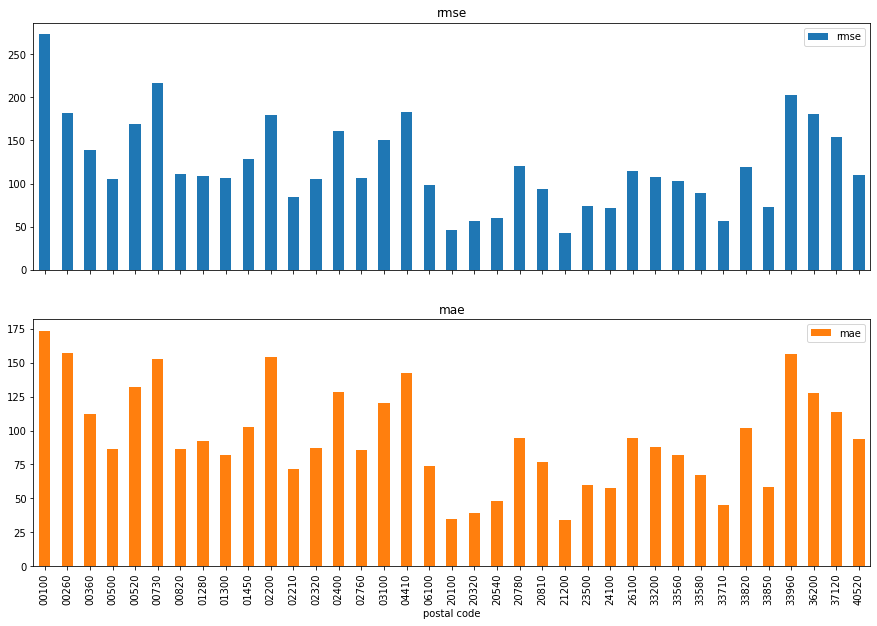

In [111]:
data.plot.bar(x="postal code", subplots=True, figsize=(15,10))

### With TAE's clustering methods

In [122]:
c_data = pd.read_csv("cluster-Copy1.csv", dtype={"Postal code": str})
data_labels = c_data[["Postal code","label2", "label4", "label5", "label7", "label8", "label10"]]

#### Disclaimer, clustered data is from imputed data. Therefore, it is not 100% accurate when predicting clusters. 

In [123]:
data_labels

,Postal code,label2,label4,label5,label7,label8,label10
0,00100,0,0,3,0,0,0
1,00100,0,0,3,0,0,0
2,00100,0,0,3,0,0,0
3,00100,0,0,3,0,0,0
4,00100,0,0,3,0,0,0
...,...,...,...,...,...,...,...
3174,99600,1,3,2,3,3,6
3175,99600,1,3,2,3,3,6
3176,99800,1,3,2,3,3,3
3177,99830,1,2,1,5,2,5
